In [1]:
from helper_fn import *
import seaborn as sns

## Downloading the following dataframes

1. df
2. df600
3. df_label: PEMAT-labelled dataset.

NOTE: https:// creates problems with word_count distribution.

In [2]:
# NOTE: df should have 56 columns because we don't have labels on actionability, understandability, etc.
df = pd.read_csv("merged_and_cleaned12k.csv", sep = ",").dropna(how = "all").drop(columns = ["Unnamed: 0"])
df600 = pd.read_csv("merged_and_cleaned600.csv", sep = ",").drop(columns = ["Unnamed: 0"])
df_label = pd.read_csv("rawPEMAT.csv", sep = ",").drop(columns = ["Unnamed: 0"])

In [3]:
# Load the dictionary of PEMAT. 
# Plan: Work back and forth between the PEMAT raw file (df_label) and the cleaned file (df600).
f = open("PEMAT_dict.pkl","rb")
PEMAT_dict = pickle.load(f)

In [4]:
# Merge videos that appear multiple times under different keywords. 
groupby_column = 'video_id'
aggregate_column = 'keyword'
agg_df = df.groupby(groupby_column).aggregate({aggregate_column: list})
df_alias = df.drop(columns=aggregate_column).set_index(groupby_column)
agg_df = agg_df.join(df_alias).reset_index(groupby_column).drop_duplicates(groupby_column).reset_index(drop=True)

df = agg_df

In [14]:
df

,video_id,keyword,ARI,FleshReadingEase,Kincaid,active_verb,has_description,id,sentence_count,summary_words,...,channelVideoCount,keyword_decription_cosine,comment_total_words,negative_comment_count,comment_description_cosine,keyword_title_cosine,comment_title_cosine,postive_comment_count,comment_unique_words,neutral_comment_count
0,--3PG0yv7xo,[insulin sensitive],7.80,75.04,6.54,91.00,1.00,--3PG0yv7xo,44.00,0.00,...,270.00,0.24,"1,381.00",5.00,5.68,0.14,1.22,36.00,"1,134.00",5.00
1,--GLJISL-sM,[glycogenolysis],32.95,-24.82,26.66,5.00,1.00,--GLJISL-sM,3.00,0.00,...,121.00,0.16,23.00,0.00,0.11,0.18,0.00,2.00,20.00,0.00
2,--KcUndJ7Tw,[Repaglinide],9.47,48.64,8.96,2.00,1.00,--KcUndJ7Tw,2.00,0.00,...,"1,069.00",0.00,0.00,0.00,0.00,0.21,0.00,0.00,0.00,0.00
3,--P1IWDqESU,[End stage renal disease],11.00,56.28,8.69,5.00,1.00,--P1IWDqESU,5.00,0.00,...,"34,681.00",0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
4,--Zx-67-FfY,[diabetic heart disease],15.32,37.55,14.14,27.00,1.00,--Zx-67-FfY,8.00,0.00,...,"1,269.00",0.04,463.00,1.00,0.53,0.17,0.38,3.00,290.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8958,zxHEWa3J-I4,[glucose test strip],15.71,31.71,13.56,3.00,1.00,zxHEWa3J-I4,2.00,0.00,...,121.00,0.07,0.00,0.00,0.00,0.36,0.00,0.00,0.00,0.00
8959,zxeKsGLpUEg,[pancreatic islet],2.26,187.64,-11.17,0.00,1.00,zxeKsGLpUEg,1.00,0.00,...,"1,025.00",0.00,0.00,0.00,0.00,0.31,0.00,0.00,0.00,0.00
8960,zyP82eAMVrU,[diabetic coma],13.56,77.04,11.21,6.00,1.00,zyP82eAMVrU,1.00,0.00,...,"25,337.00",0.00,0.00,0.00,0.00,0.36,0.00,0.00,0.00,0.00
8961,zz-zF1w2WwY,[glucose tolerance],0.00,0.00,0.00,0.00,0.00,zz-zF1w2WwY,0.00,0.00,...,16.00,0.00,0.00,0.00,0.00,0.61,0.00,0.00,0.00,0.00


# PART 1: Descriptive Statistics

First, I examined the features and classified them into three categories. 
1. Video metadata
2. Video 
3. Usage statistics



**NOTE: See merge_and_cleaned for a description on the PEMAT labels. This is a descriptive statistics on the entire dataset.

## Useful resource
1. ARI: https://en.wikipedia.org/wiki/Automated_readability_index
2. Flesch reading ease:
3. Kincaid (formally titled: Flesch-Kincaid readability). https://readable.com/readability/flesch-reading-ease-flesch-kincaid-grade-level/
4. Cosine similarity: https://www.machinelearningplus.com/nlp/cosine-similarity/

## Appropriate ranges
1. ARI: 1-14
2. Kincaid: 0-19; 
3. Flesch: 0-100.
4. cosine similarity -1 to 1; 

In [38]:
# Checking the summary statistics for each of these features. 
fare = ["min", "max", "median", "mean", "std"]
temp = {}

# Labels
label = ["understand","action", "info"]

# Video metadata
readable = ['ARI', 'FleshReadingEase','Kincaid']

# Derivatives of video metadata
description_d = ["word_unique", "transition_words","summary_words","active_verb", "word_count", "sentence_count"]
keyword = ['keyword_title_cosine', 'keyword_decription_cosine']
channel = ['channelSubscriberCount', "channelViewCount", "channelCommentCount", "channelVideoCount"] # TODO: Log
duration = ["video_duration"] # Is already an integer
license = ["contentLicensed"]

# Miscellaneous
rank = ["rank"]
content = ["contentDefinition", "contentLicensed"]

# Usage statistics (outcome metrics)
like_dislike_view = ["likeCount", "dislikeCount", "viewCount"] # TODO: Log-transform
comment_cosine = ['comment_title_cosine', 'comment_description_cosine']
comment_d = ['commentCount','postive_comment_count','negative_comment_count','neutral_comment_count', 
           "comment_unique_words", "comment_total_words"]

dependent = label
numeric = readable + description_d + keyword + channel + duration + like_dislike_view + comment_cosine + comment_d
categoric = license + content
misc = rank

In [9]:
def comparisonTable(df, dependent, to_summarize, fare = ["min", "max", "median", "mean", "std"] ):
    assert dependent in ["info", "action", "understand", "misinfo"]
    # Define df_i as a dataframe with dependent variable = i. 
    df_1 = df[df[dependent] == 1]
    df_0 = df[df[dependent] == 0] 
    summary_lst = [summaryStatistics(df_0, to_summarize, fare = fare), 
                   summaryStatistics(df_1, to_summarize, fare=fare)]
    newdf = pd.DataFrame(index = fare)
    for feature in to_summarize:
        for i in range(2):
            col_name = feature + "_%s_%s" %(dependent, str(i))
            newdf[col_name] = summary_lst[i][feature]
    return newdf

to_save600 = comparisonTable(df600, "understand", numeric).T
to_save600.to_csv("label_summary.csv")

In [15]:
to_save8900 = summaryStatistics(df, numeric, fare = ["min", "max", "median", "mean", "std"]).T
to_save8900.to_csv("all_summary.csv")

/Users/lerdp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


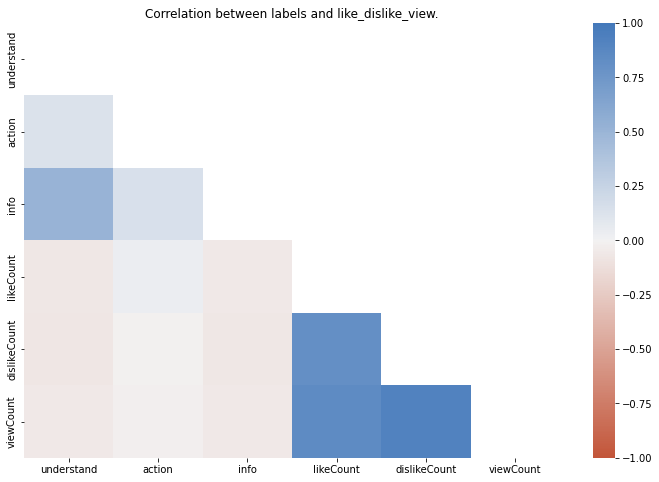

In [55]:
# Plotting heatmap 
var_lst = ["readable", "description_d", "keyword", "channel", "duration", "like_dislike_view"]
var_lst += ["comment_cosine", "comment_d"]
var = var_lst[5]
title = "label_%s" %(like_dislike_view) + ".png"
cmap = sns.diverging_palette(20, 250, as_cmap=True)
fig, ax = plt.subplots(figsize = (12,8))
corr = df600[label + like_dislike_view].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Building dataframe
ax = sns.heatmap(corr, cmap = cmap, mask=mask, vmin = -1, vmax = 1)
ax.set_title("Correlation between labels and %s." %(var))
fig.savefig(title)

In [211]:
fare = ["min", "max"]
temp = pd.DataFrame(index = fare)
temp["cat"] = [1,0]
temp

,cat
min,1
max,0


In [68]:
def boxplotVisualizer(df, dependent, feature_lst, title, figsize = (15,10), truncate = False, log_transform = False,
                     isGrid = False, layout = (2,3)):
    """
    @param df: A dataframe whose columns consist of numerical variables we want to visualize (boxplot).
    @param dependent: A string name of dependent variable for which we want to create a boxplot.
    @param feature_lst: A list of feature names (str).
    @param col_category: A string denoting the group of columns we wish to create boxplot altogether,
                         such as readability, viewer engagement. This will appear as suptitle.
    @param log_transform: If we want to log-transform each variable before visualizing. 
    ---- Fancy functionality -----
    @param isGrid: A Boolean variable denoting whether we want to stack everything or create one grid.
    @param layout: A tuple og grid dimensions.
    -----------------------------
    Return: A boxplot figure. 
    Usage: Identify which numerical variables may be relevant to our classification tasks. For Rema.
    TODO: Implement value truncation
    TODO(Fancy): Grid plot. 
    """
    # Checking veracity of input variables.
    assert dependent in ["info", "action", "understand", "misinfo"]
    for col in feature_lst:
        assert col in df.columns.tolist()
        
    # Create a copy of dataframe to transform variables without messing the dataframe
    dfcopy = df[feature_lst + [dependent]].copy()
    transform_info = ""
    
    # Apply log-transformation (NOTE: +10 is to prevent error with log(0)).
    if log_transform:
        transform_info = "log_transformed"
        for col in feature_lst:
            dfcopy[col] = np.log10(dfcopy[col] + 10)
    
    """
    # Generate the indices by which we create plots.
    # NOTE: Plots are created left to right, up to down. 
    assert len(feature_lst) == layout[0]*layout[1]
    if isGrid:
        nrow = layout[0]
        ncol = layout[1]
        x_iter = np.repeat(np.arange(0,ncol,1), nrow, axis = 0)
        y_iter = np.tile(np.arange(0,nrow,1), ncol)
    """
    # Create multiple subplots
    fig, ax = plt.subplots(1, len(feature_lst), figsize = figsize)
    fig.suptitle('Boxplots on %s for %s groups (%s).' %(title, dependent.upper(), transform_info))
    for i, col in enumerate(feature_lst):
        """
        if isGrid:
            cur_ax = ax[x_iter[i], y_iter[i]]
        else:
            cur_ax = ax[i]
        """
        # NOTE: If len(feature_lst) = 1, ax returns a subplot itself (hence, cannot index).
        if len(feature_lst) <= 1:
            cur_ax = ax
        else:
            cur_ax = ax[i]
        cur_ax.set_title("%s" %(col))
        cur_ax.grid()
        sns.boxplot(ax = cur_ax, data = dfcopy, x = dependent, y = col)
    return fig

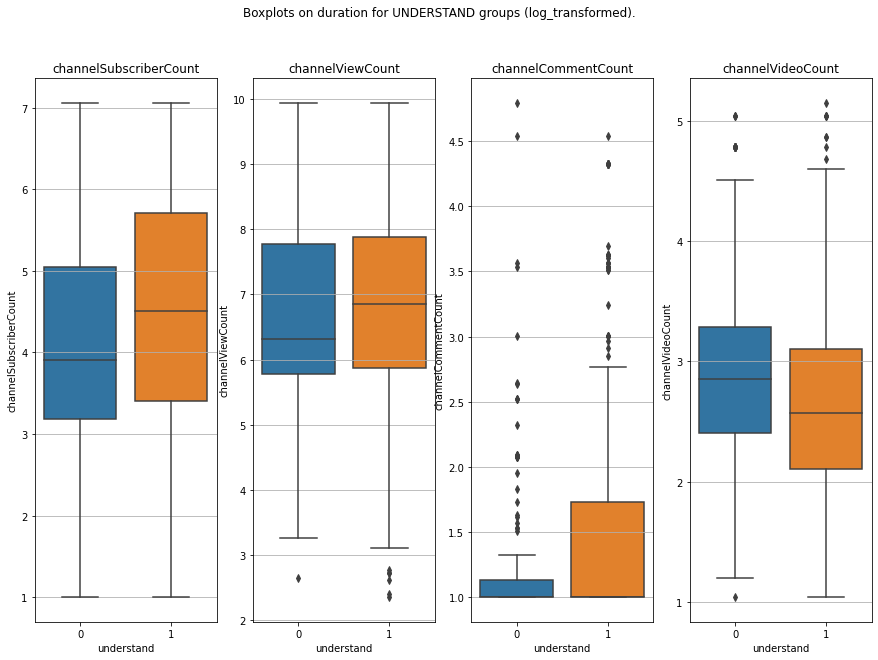

In [76]:
# TODO: Like-dislike/viewCount ratio. 
dep_lst = ["understand", "action", "info"]
dependent = dep_lst[0]

feature_name = "channel"
title = "duration"
fig = boxplotVisualizer(df600, dependent, channel, title = title,
                        log_transform = True)
title = "boxplot_%s_%s" %(dependent,feature_name)
fig.savefig(title)

In [ ]:
df600nu["ARI"]

In [ ]:
# Many channels have large total views. PCA for highly correlated variables?
var = "channelViewCount"
thresh = 10**6
col = ["rank", "keyword", "id", "understand", "title", "channelTitle"]
df600[df600[var] > thresh][col]

In [ ]:
# Perform histogram of the dataset.
var = "channelVideoCount"
entire = True

if entire == True:
    x = df[var]
    name = "entire dataset"
else:
    x = df600[var]
    name = "labelled dataset"
bins = [2**i for i in range(7)]
fig = plt.hist(x, density = False, facecolor='b', alpha=0.75)
plt.xlabel('%s' %(var))
plt.ylabel('Number of videos')
plt.title('%s distribution on %s' %(var,name))
plt.grid(True)

In [ ]:
# Check if columns of df600 and df are the same.
# Only difference: video_duration, understand, action, URL, which all appear in other forms already.
for col in df600.columns.tolist():
    if col not in df.columns.tolist():
        print(col)

In [ ]:
df600["contentLicensed"].value_counts()

# PART 2: Building models
In this part, I used Kincaid as a response variable. The dataset is the miniature 600 versions whereby we have the labels. The logistic regression model is built upon only numerical values. Overall, the accuracy is egregiously high (80%), suggesting that I might overfit?

In [ ]:
# Drop the indices with no_info. 
# Why: I have checked the data. These rows contains many NaN.
no_info = np.where(df600["info"].isna() == True)[0].tolist()
no_info += np.where(df600["viewCount"].isna() == True)[0].tolist()
df600 = df600.drop(index = no_info, columns = ["Unnamed: 0"])

In [ ]:
# Feature transform the readability indices
# Thought 1: Select only ARI due to highly corrleated

# ARI should be from 0-14
ub = 14
lb = 0
truncateColumn(df600, lb, ub, "ARI")
summaryStatistics(df, ["has_description"])

In [ ]:
need_to_dummy = ["contentDefinition"]
df600 = pd.get_dummies(df600, columns = need_to_dummy)
df600

# Results of each classification model

In [ ]:
# Model 1: Use every numerical variable
unsure = ["has_description"] + ["active_verb"]
sure = duration + keyword + ["ARI"] 

X = df600[sure + unsure]
y = df600["understand"]

# Set random_state = 1 to compare between models. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size = 0.12, random_state = 1)

In [ ]:
# Testing for logistic regression
model_name = "Logistic"
X_test, y_test, model = testClassifier(X, y, model_name)
createROC(X_test, y_test, model, model_name)

In [ ]:
# Testing SVM
model_name = "SVM"
grid = {'kernel':['rbf'], 'C': np.arange(1,10,2)}
X_test, y_test, model = testClassifier(X, y, model_name, parameters = grid)
createROC(X_test, y_test, model, model_name)

In [ ]:
# Testing Random Forest
n_estimators = np.arange(10, 200, 20)
max_depth = np.arange(1,5)
grid = {'n_estimators':n_estimators, 'max_depth':max_depth}
model_name = "RandomForest"
X_test, y_test, model = testClassifier(X, y, model_name, parameters = grid)
createROC(X_test, y_test, model, model_name)

In [ ]:
temp = 0
for i in df["subtitle"].index.tolist():
    if len(df.iloc[i]["subtitle"]) > 20:
        temp += 1
print(temp)

# Performing topic modelling